In [84]:
# Import necessary libraries
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import date
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud
from itertools import combinations


#Set up Selenium driver options
options = Options()
options.add_argument("--window-size=1920,1200")

#Set up visualisation settings
plt.style.use('fivethirtyeight')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = 15,7
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

today = date.today().strftime("%d-%m-%y")


In [85]:
#Set up drover path and start the driver
DRIVER_PATH = 'path\to\chromedriver.exe'
driver = webdriver.Chrome(options=options, service=Service(DRIVER_PATH))
query = 'data analyst'

#Navigate to job search website and search for jobs related to Data Analyst
driver.get("https://www.mycareersfuture.gov.sg/")
element=driver.find_element(By.ID,"search-text")
element.send_keys(query)
element.send_keys(Keys.RETURN)
WebDriverWait(driver,15).until(EC.visibility_of_element_located((By.ID,f"job-card-0")))

#Set up empty Pandas Dataframe to store scraped data
df_new = pd.DataFrame(columns = ['sn','date_added', 'company','job','employment','min_experience','seniority','sector','min_salary','max_salary','salary_freq','description','skills'])


In [86]:
#Function to scrape data a single page
def scrapepage():
    for i in range(0,22):
        try:
            WebDriverWait(driver, 15).until(EC.visibility_of_element_located((By.ID,f"job-card-{i}")))
            driver.find_element(By.ID,f"job-card-{i}").click()
            WebDriverWait(driver, 15).until(EC.visibility_of_element_located((By.XPATH,'//*[@id="job_title"]')))
            company=driver.find_element(By.XPATH,f'//*[@id="job-details"]/div[1]/div[3]/div/section[1]/p').text
            job=driver.find_element(By.XPATH,f'//*[@id="job_title"]').text
            text=driver.find_element(By.XPATH,'//*[@id="job_description"]').text
            sn=driver.find_element(By.XPATH,f'//*[@id="job-details"]/div[1]/div[3]/div/span').text
            
            try:
                minsalary=driver.find_element(By.XPATH,f'//*[@id="job-details"]/div[1]/div[3]/div/div/section[2]/div/span[2]/div/span[1]').text.replace("$","").replace(",","")
            except:
                minsalary=np.nan
            try:
                maxsalary=driver.find_element(By.XPATH,f'//*[@id="job-details"]/div[1]/div[3]/div/div/section[2]/div/span[2]/div/span[2]').text.replace("to$","").replace(",","")
            except:
                maxsalary=np.nan
            try:
                salaryfreq=driver.find_element(By.XPATH,f'//*[@id="job-details"]/div[1]/div[3]/div/div/section[2]/div/span[3]').text
            except:
                salaryfreq=np.nan
            try:
                employment=driver.find_element(By.XPATH,f'//*[@id="employment_type"]').text
            except:
                employment=np.nan
            try:
                min_experience=driver.find_element(By.XPATH,f'//*[@id="min_experience"]').text.replace(' years exp','').replace(' year exp','')
            except:
                min_experience=np.nan
            try:
                seniority=driver.find_element(By.XPATH,f'//*[@id="seniority"]').text
            except:
                seniority=np.nan
            try:
                sector=driver.find_element(By.XPATH,f'//*[@id="job-categories"]').text
            except:
                sector=np.nan
            try:
                skills=driver.find_element(By.XPATH,'//*[@id="skills-needed"]').text.replace('Add these skills if you have them\n','').replace('\n',', ')
            except:
                skills=np.nan
                
            data = [sn, today, company, job, employment, min_experience, seniority, sector, minsalary, maxsalary, salaryfreq, text, skills]
            df_new.loc[len(df_new)] = data
            driver.execute_script("window.history.go(-1)")
            
        except:
            print(f"Error after job posting #{i}: {job} for {company}")

#Function to scrape data from 10 pages using previous defined function
def scrapetenpages():
    for page in range(1,11):
        e=0
        try:
            scrapepage()
            t = time.strftime("%H:%M:%S", time.localtime())
            print(f"Page {page} completed at {t}.")
            if driver.find_elements(By.CSS_SELECTOR,"[aria-label=Next]"):
                driver.find_elements(By.CSS_SELECTOR,"[aria-label=Next]").click()
            else:
                driver.quit()
        except:
            e+=1
            if e==3:
                driver.quit() 
    driver.quit()
    

In [87]:
#Call 'scrapetenpages' to extract job details from 10 pages of search results
#Continue to next job card (if any) if any error occurred
scrapetenpages()

Page 1 completed at 20:39:05.
Page 2 completed at 20:39:37.
Page 3 completed at 20:40:10.
Page 4 completed at 20:40:45.
Page 5 completed at 20:41:25.
Page 6 completed at 20:42:05.
Page 7 completed at 20:42:48.
Page 8 completed at 20:43:31.


In [88]:
#Convert 'min_salary', 'max_salary' and 'min_experience' columns to integer data type
df_new['min_salary'] = df_new['min_salary'].astype('Int64')
df_new['max_salary'] = df_new['max_salary'].astype('Int64')
df_new['min_experience'] = df_new['min_experience'].astype('Int64')

Next step depends if it is new dataset or merging with existing dataset

In [89]:
'''#1. Export data into a new CSV file''' 
# df = df_new
# df.to_csv(f"MyCareersFuture {query.title()} Dataset.csv", index=False)
# df

'''#2. Append to existing dataset''' 
#Load existing dataset
df_1 = pd.read_csv(f"MyCareersFuture {query.title()} Dataset.csv")

#Add new dataset to bottom of current dataset
df = pd.concat([df_1, df_new])

#Drop duplicates based on serial number and keep the latest entry
df = df.drop_duplicates(subset='sn',keep='first').reset_index(drop=True)
df.to_csv(f"MyCareersFuture {query.title()} Dataset.csv", index=False)

#Show the dataframe
df

,sn,date_added,company,job,employment,min_experience,seniority,sector,min_salary,max_salary,salary_freq,description,skills
0,MCF-2023-0045798,16-02-23,HELIUS TECHNOLOGIES PTE. LTD.,Data Analyst,Contract,3.0,Executive,Banking and Finance,3500.0,4000.0,Monthly,Roles & Responsibilities\r\nResponsibilities\r...,"Tableau, Wireframes, Management Skills, Busine..."
1,MCF-2023-0048331,16-02-23,GAMETION GLOBAL TECHNOLOGIES PTE. LIMITED,Data Analyst,Permanent,3.0,Executive,Others,3500.0,5000.0,Monthly,Roles & Responsibilities\r\nData Analyst\r\nRo...,"CRM, Machine Learning, OBIEE, Oracle, HTML, Bu..."
2,MCF-2023-0045811,16-02-23,CASTLERY PRIVATE LIMITED,Data Engineer,"Permanent, Full Time",4.0,Professional,Information Technology,4000.0,9000.0,Monthly,Roles & Responsibilities\r\nCastlery is lookin...,"Business Intelligence, Pandas, Data Analysis, ..."
3,MCF-2022-0964129,16-02-23,ALCON SINGAPORE MANUFACTURING PTE. LTD.,IT Business and Data Analyst,"Permanent, Full Time",4.0,Executive,"Information Technology, Manufacturing",5500.0,8000.0,Monthly,Roles & Responsibilities\r\nJob Summary:\r\nAl...,"Tableau, Business Continuity, Data Management,..."
4,MCF-2022-0940286,16-02-23,ALCON SINGAPORE MANUFACTURING PTE. LTD.,Senior IT Business & Data Analyst,"Permanent, Full Time",4.0,Middle Management,Information Technology,5000.0,7000.0,Monthly,Roles & Responsibilities\r\nJob Purpose\r\nThi...,"Tableau, Data Management, Cognos, Scripting, E..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,MCF-2023-0108284,17-02-23,R SYSTEMS (SINGAPORE) PTE LIMITED,Business Analyst (ESG & Data Management),Contract,4.0,Professional,"Banking and Finance, Information Technology",8000.0,12000.0,Monthly,Roles & Responsibilities\nThe role is expected...,"Analytical Skills, Big Data, User Stories, Bus..."
204,MCF-2023-0110819,17-02-23,RECRUIT EXPRESS PTE LTD,Affiliate Data Analyst,Contract,3.0,Executive,Information Technology,8000.0,15000.0,Monthly,Roles & Responsibilities\nJob Description:\n\n...,"Tableau, Business Intelligence, Data Analysis,..."
205,MCF-2023-0080618,17-02-23,MORGAN MCKINLEY PTE. LTD.,Data Analyst (Asset Management),Contract,5.0,Professional,Information Technology,7500.0,10000.0,Monthly,Roles & Responsibilities\nWe are looking for D...,"Work Autonomously, Negotiation, Tableau, Asset..."
206,MCF-2023-0086414,17-02-23,WSH EXPERTS PTE. LTD.,Household Data Research Analyst,Full Time,3.0,Executive,"Customer Service, Design, Information Technology",5000.0,6000.0,Monthly,Roles & Responsibilities\n• Individuals who en...,"Tableau, Market Research, Microsoft PowerPoint..."


In [90]:
#Remove "Data Analytics" and "Data Analysis" from Skills column
df['skills'] = df['skills'].str.replace('Data Analysis, ', '')
df['skills'] = df['skills'].str.replace('Data Analytics, ', '')


Visualise skills ranked by number of occurences in all job postings

In [91]:
#Create list of skills from 'skills' column, count the frequency of each skill and sort the results
sorted_skills = df['skills'].str.split(', ').explode('skills').value_counts()

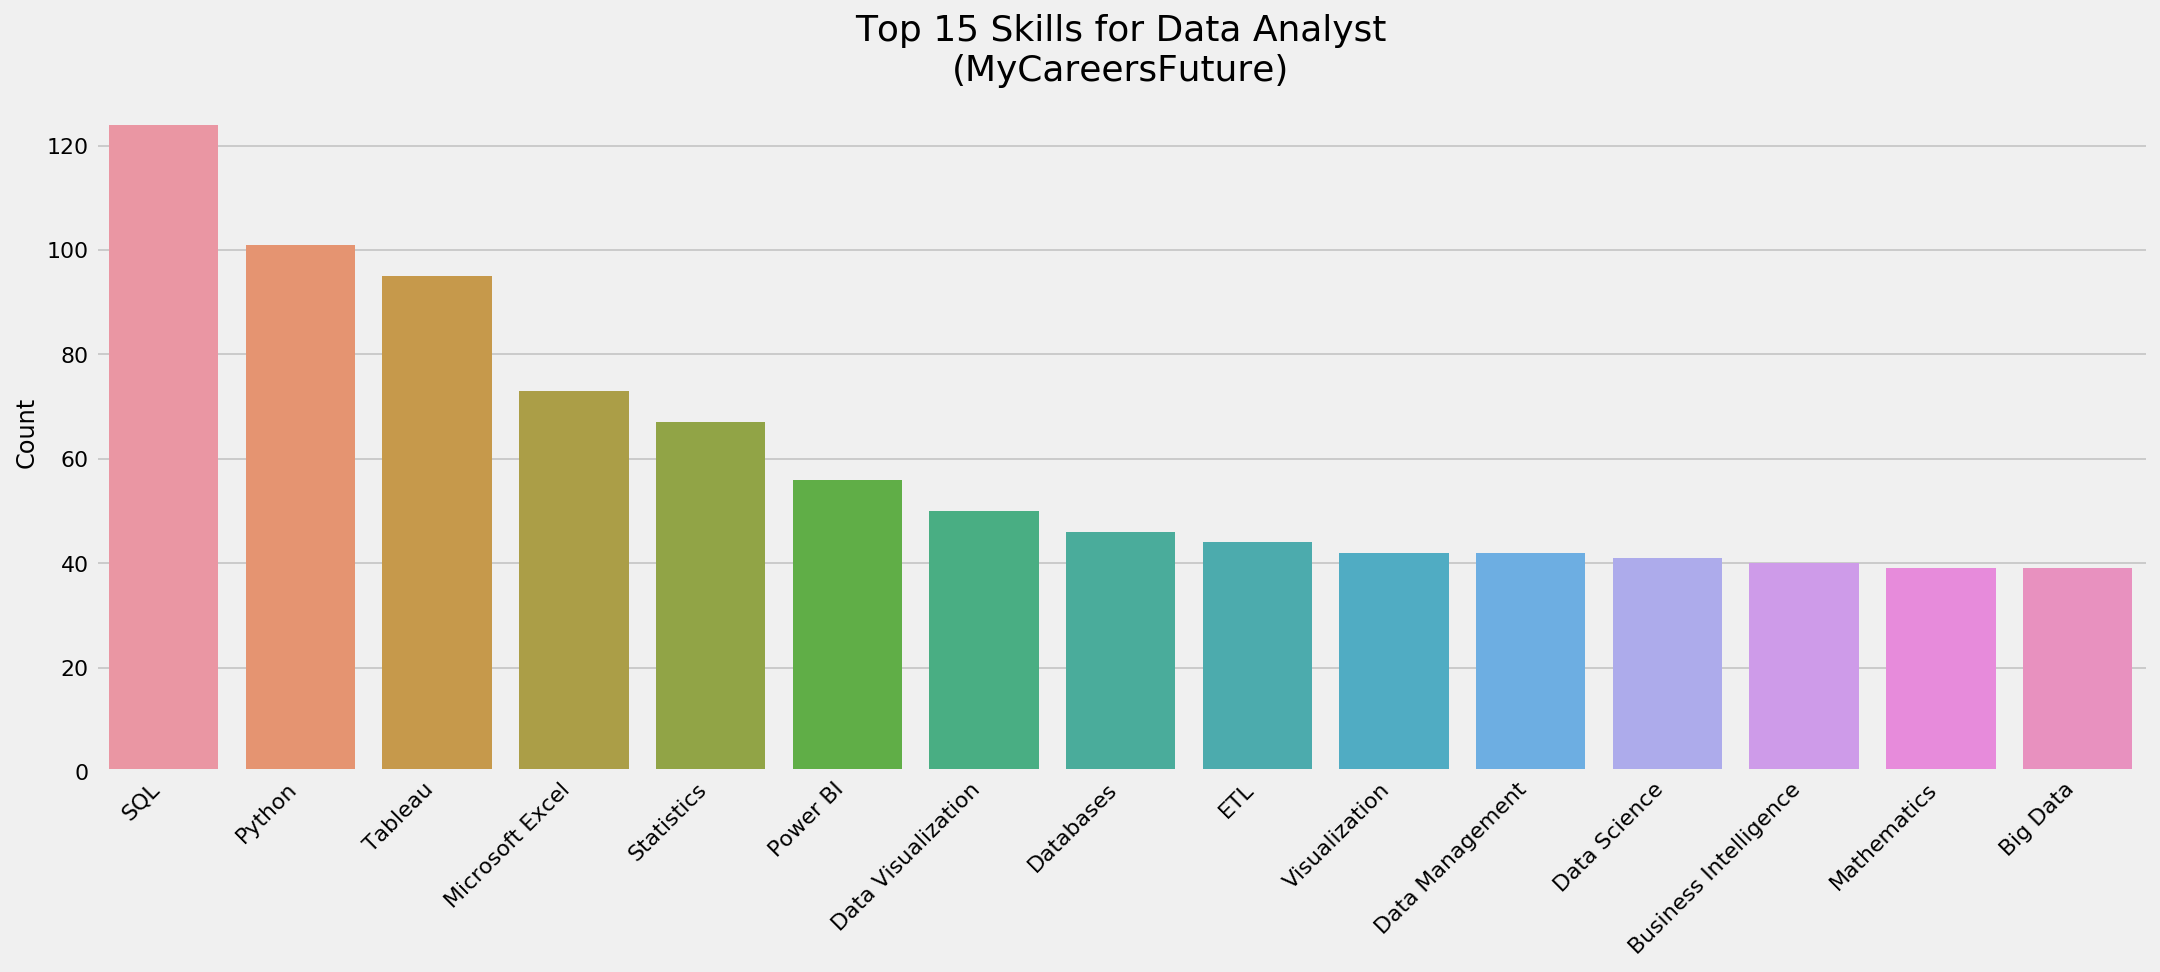

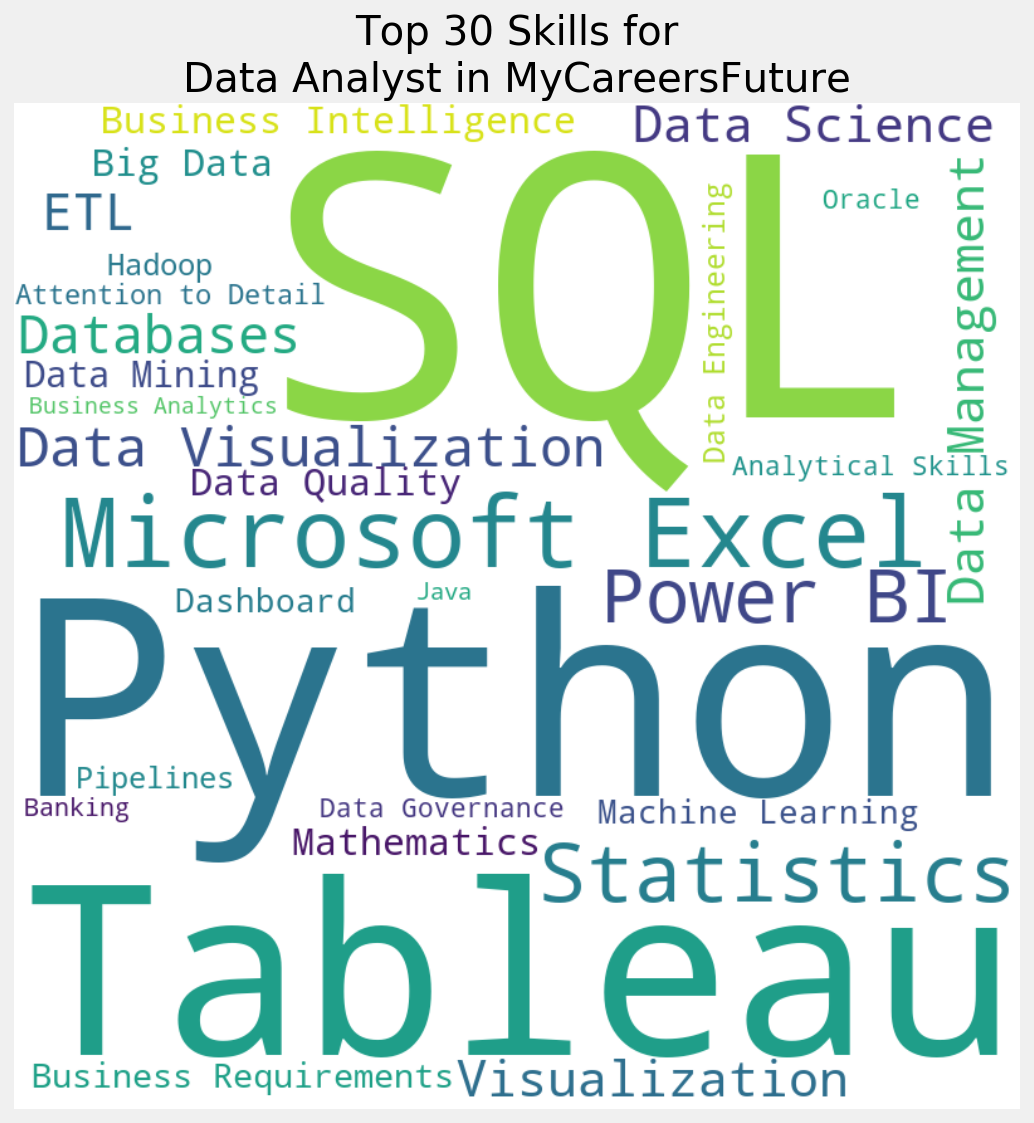

The top 5 skills expected of a Data Analyst are
        #1. SQL - 124
        #2. Python - 101
        #3. Tableau - 95
        #4. Microsoft Excel - 73
        #5. Statistics - 67
        


In [106]:
#Create bar plot showing the top 15 most frequently mentioned skills in dataset
g = sns.barplot(x=sorted_skills.head(15).index, y=sorted_skills.head(15).values)

plt.xticks(rotation = 45, ha='right')
plt.title(f"Top 15 Skills for {query.title()}\n(MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.ylabel('Count', fontsize=12)
plt.show()

#Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, max_words=30).generate_from_frequencies(sorted_skills) 
plt.figure(figsize=(8,8), facecolor=None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title(f"Top 30 Skills for\n{query.title()} in MyCareersFuture")
plt.tight_layout() 
plt.show()

print(f"""The top 5 skills expected of a {query.title()} are
        #1. {sorted_skills.index[0]} - {sorted_skills[0]}
        #2. {sorted_skills.index[1]} - {sorted_skills[1]}
        #3. {sorted_skills.index[2]} - {sorted_skills[2]}
        #4. {sorted_skills.index[3]} - {sorted_skills[3]}
        #5. {sorted_skills.index[4]} - {sorted_skills[4]}
        """)

Correlation Between Different Skills Mentioned

In [94]:
#create a list of skills for each row
skills_list = df['skills'].str.split(', ')

#create a set of all unique skills
all_skills = set(skills_list.explode().unique())

#make new co-occurrence matrix
co_matrix = pd.DataFrame(0, columns=all_skills, index=all_skills)

In [95]:
#loop through each row and update the co-occurrence matrix
for skills in skills_list:
    for s1, s2 in combinations(skills, 2):
        co_matrix.loc[s1, s2] += 1
        co_matrix.loc[s2, s1] += 1

#filter to show only pairs that occur more than 50 times together
co_matrix_filtered = co_matrix[(co_matrix > (co_matrix.max().max()*0.5))].dropna(how='all', axis=0).dropna(how='all', axis=1)

print(f"High Co-Occurrence Pairs of Skills Expected of a {query.title()}:")
for i, word1 in enumerate(co_matrix_filtered.columns):
    for word2 in co_matrix_filtered.index[i+1:]:
        count = co_matrix_filtered.loc[word1, word2]
        if pd.notna(count)==True:
            print(f' => {word1} - {word2}')

High Co-Occurrence Pairs of Skills Expected of a Data Analyst:
 => Microsoft Excel - SQL
 => Microsoft Excel - Tableau
 => SQL - Python
 => SQL - Statistics
 => SQL - Tableau
 => Python - Statistics
 => Python - Tableau
 => Statistics - Tableau


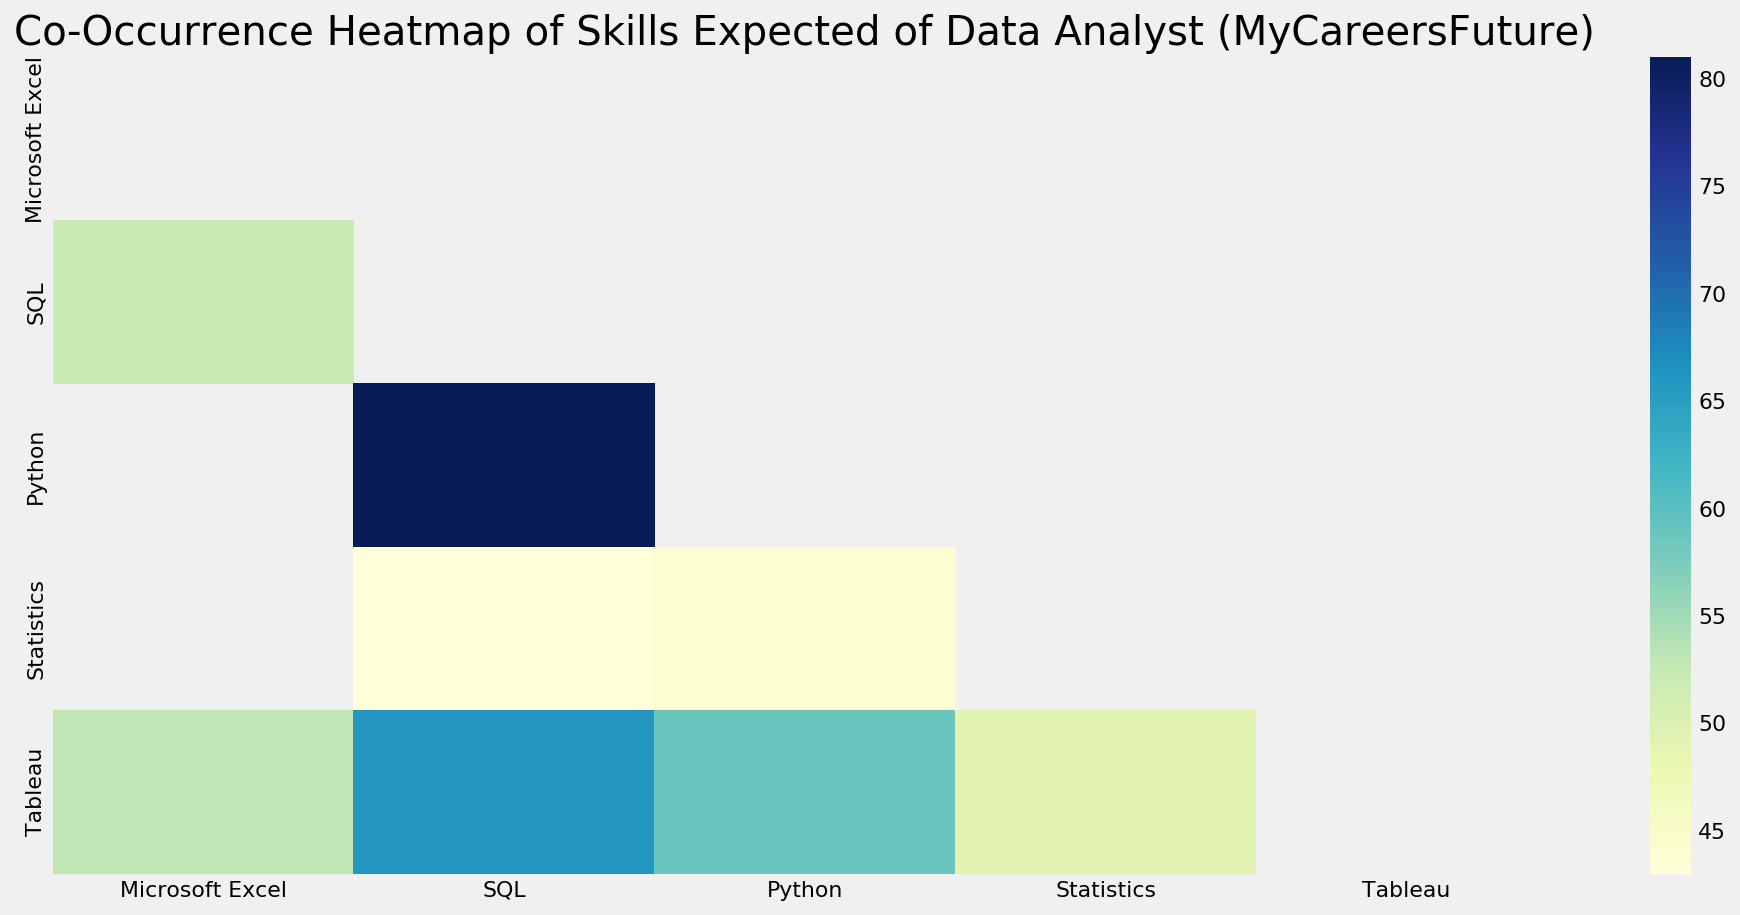

In [96]:
#hide upper triangle
mask = np.triu(np.ones_like(co_matrix_filtered, dtype=bool))

#create a heatmap of the co-occurrence matrix, with the mask applied
sns.heatmap(co_matrix_filtered, cmap='YlGnBu', mask=mask)
plt.title(f"Co-Occurrence Heatmap of Skills Expected of {query.title()} (MyCareersFuture)")
plt.show()

Visualise salary range from all job postings

In [97]:
#Calculate midrange salary for each job listing
df['midrange_salary'] = (df['max_salary']+df['min_salary'])/2

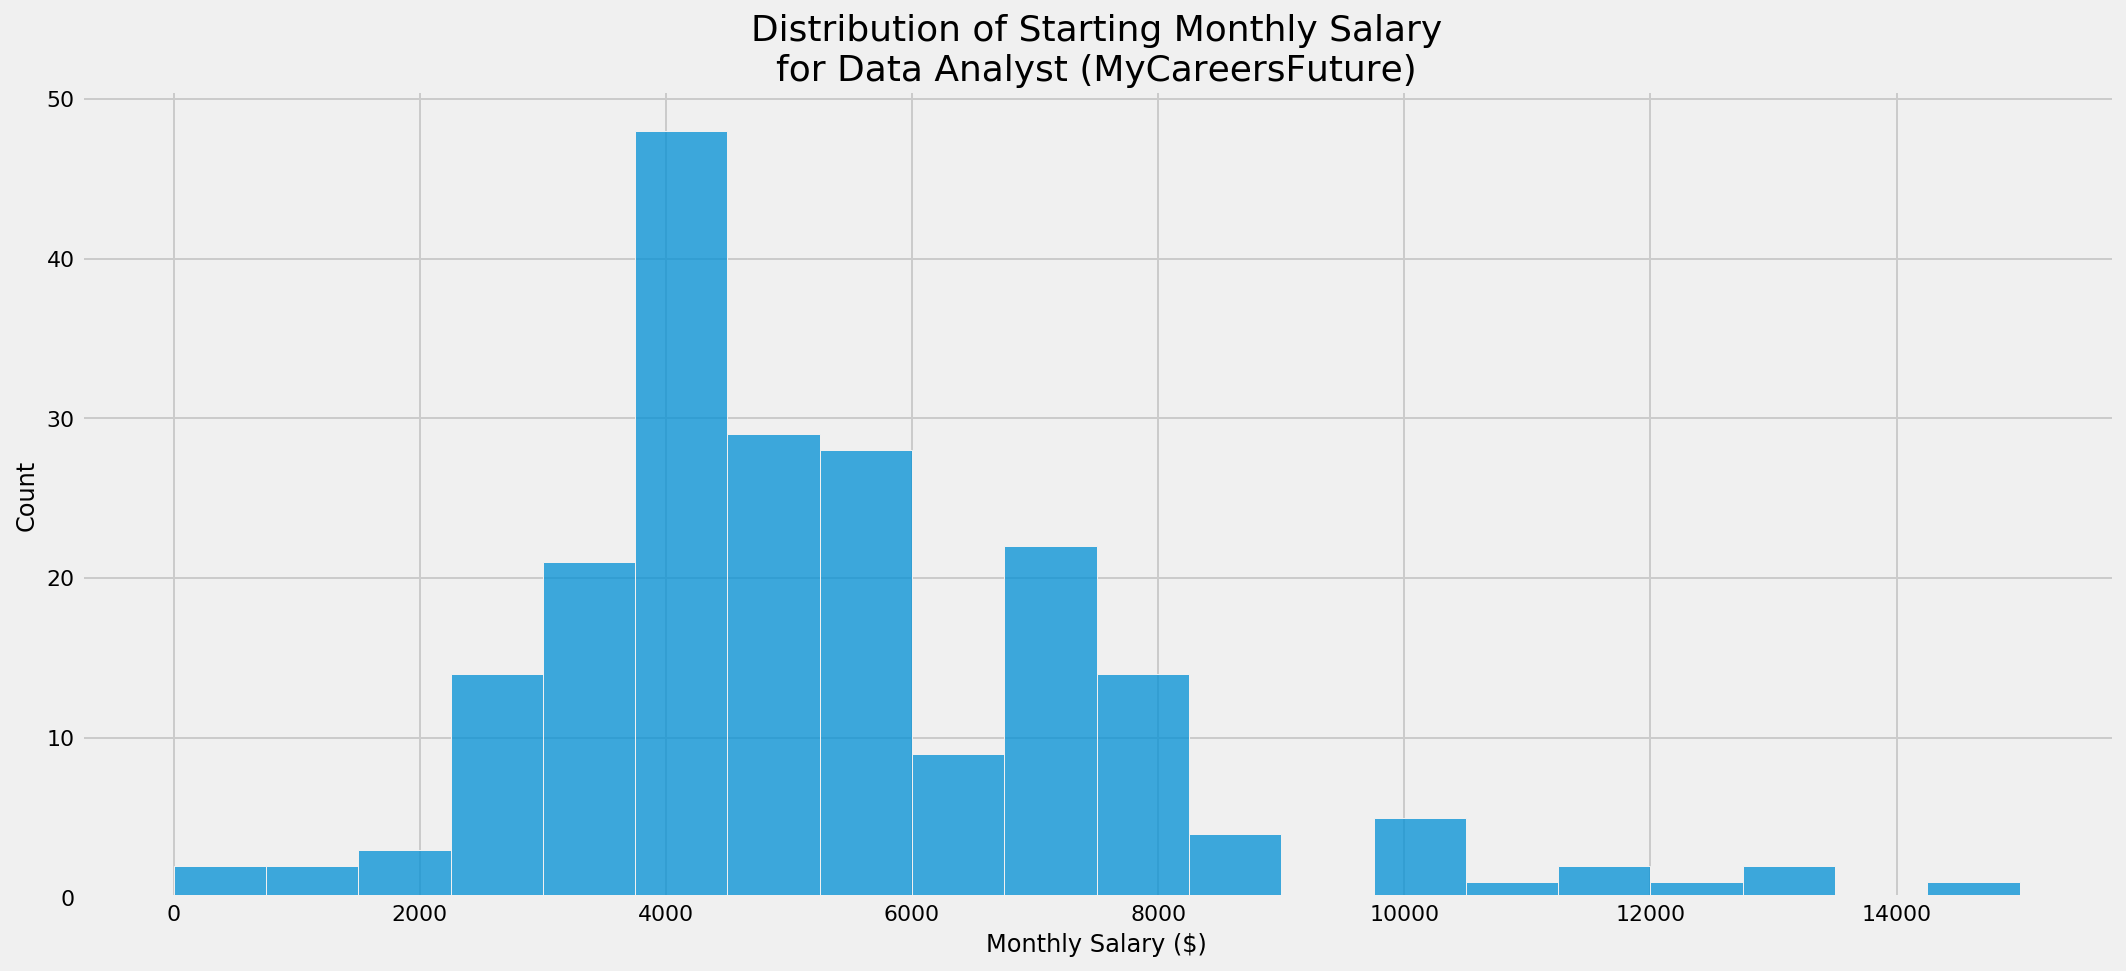

Listed Starting Salary for Data Analyst:
    Mean: $5417
    Median: $5000
    Min: $1
    Max: $15000



In [98]:
#Plot histogram of the midrange salaries
g_minsal = sns.histplot(data=df,x='min_salary',bins=20)
plt.xlabel("Monthly Salary ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Distribution of Starting Monthly Salary\nfor {query.title()} (MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

print(f"""Listed Starting Salary for {query.title()}:
    Mean: ${int(df['min_salary'].mean())}
    Median: ${int(df['min_salary'].median())}
    Min: ${int(df['min_salary'].min())}
    Max: ${int(df['min_salary'].max())}
""")

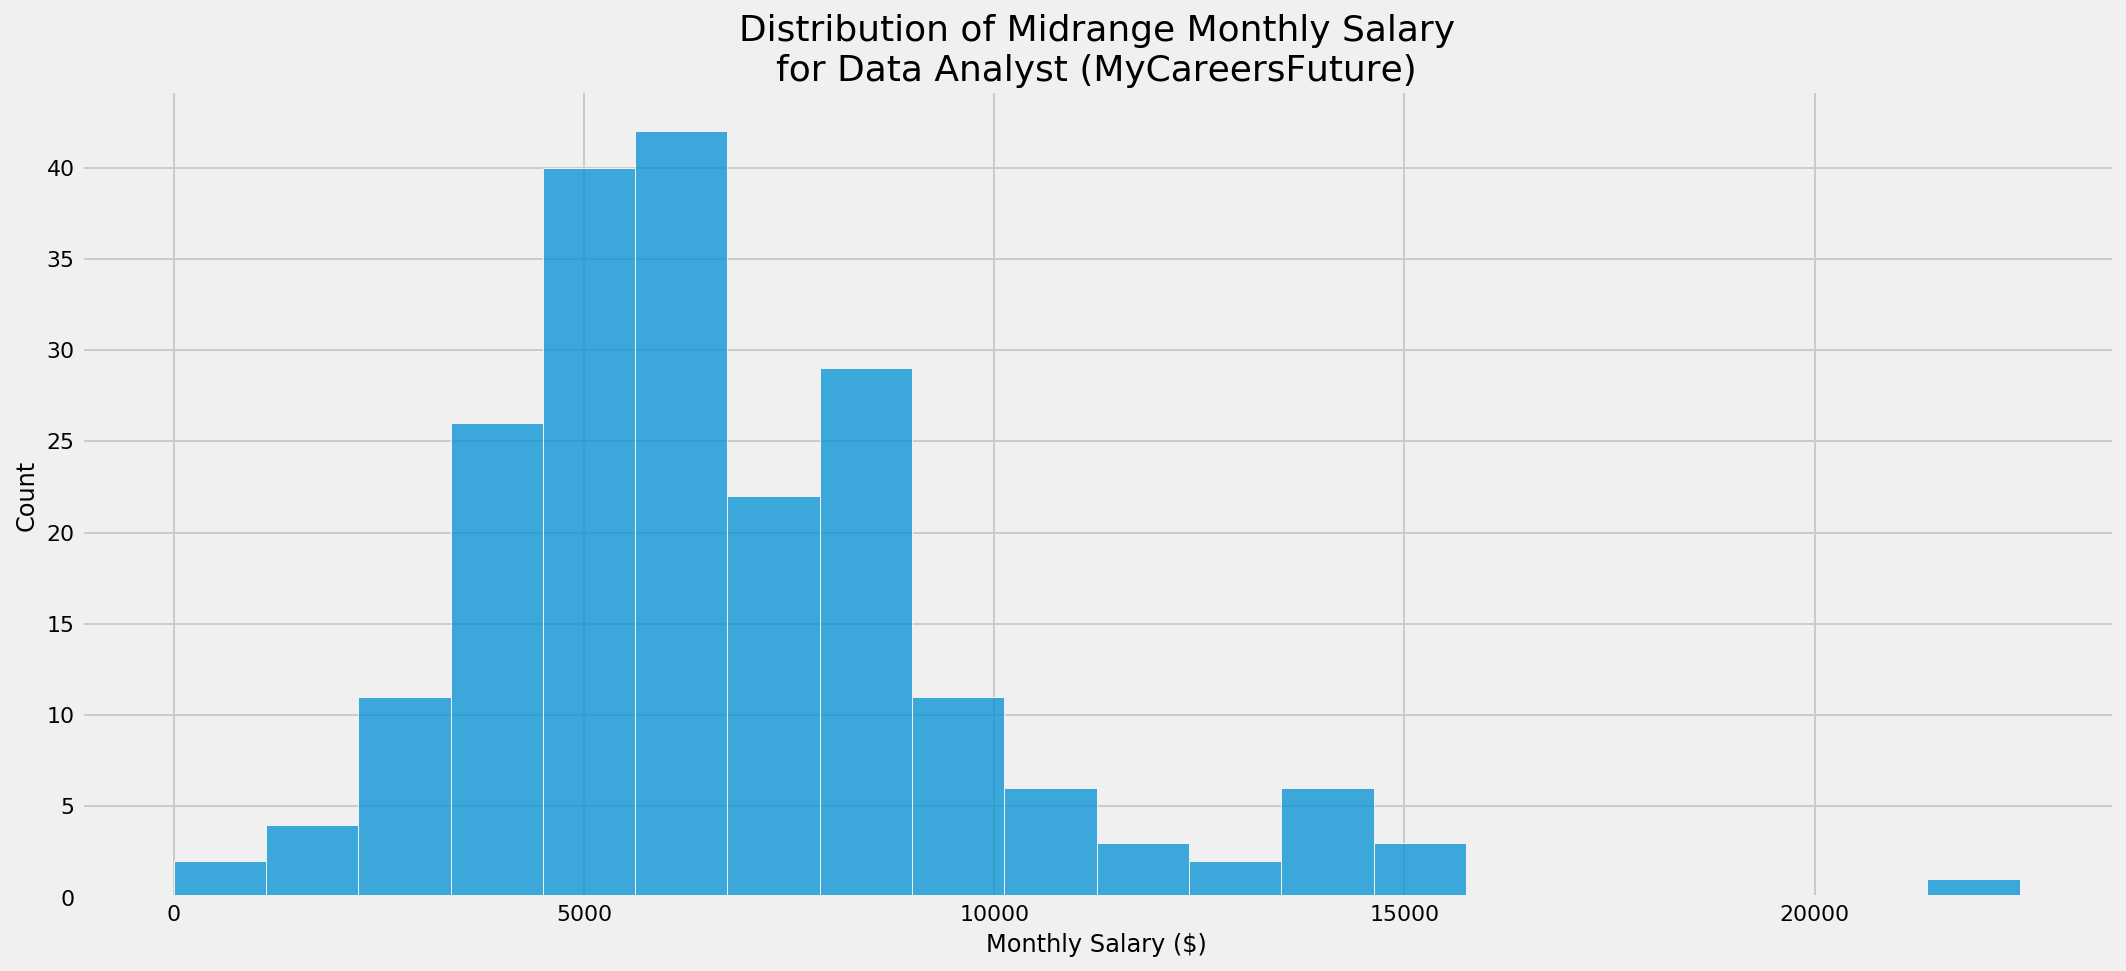

Listed Midrange Salary for Data Analyst:
    Mean: $6788
    Median: $6250
    Min: $1
    Max: $22500



In [99]:
#Plot histogram of the midrange salaries
g_sal = sns.histplot(data=df,x='midrange_salary',bins=20)
plt.xlabel("Monthly Salary ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Distribution of Midrange Monthly Salary\nfor {query.title()} (MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

print(f"""Listed Midrange Salary for {query.title()}:
    Mean: ${int(df['midrange_salary'].mean())}
    Median: ${int(df['midrange_salary'].median())}
    Min: ${int(df['midrange_salary'].min())}
    Max: ${int(df['midrange_salary'].max())}
""")

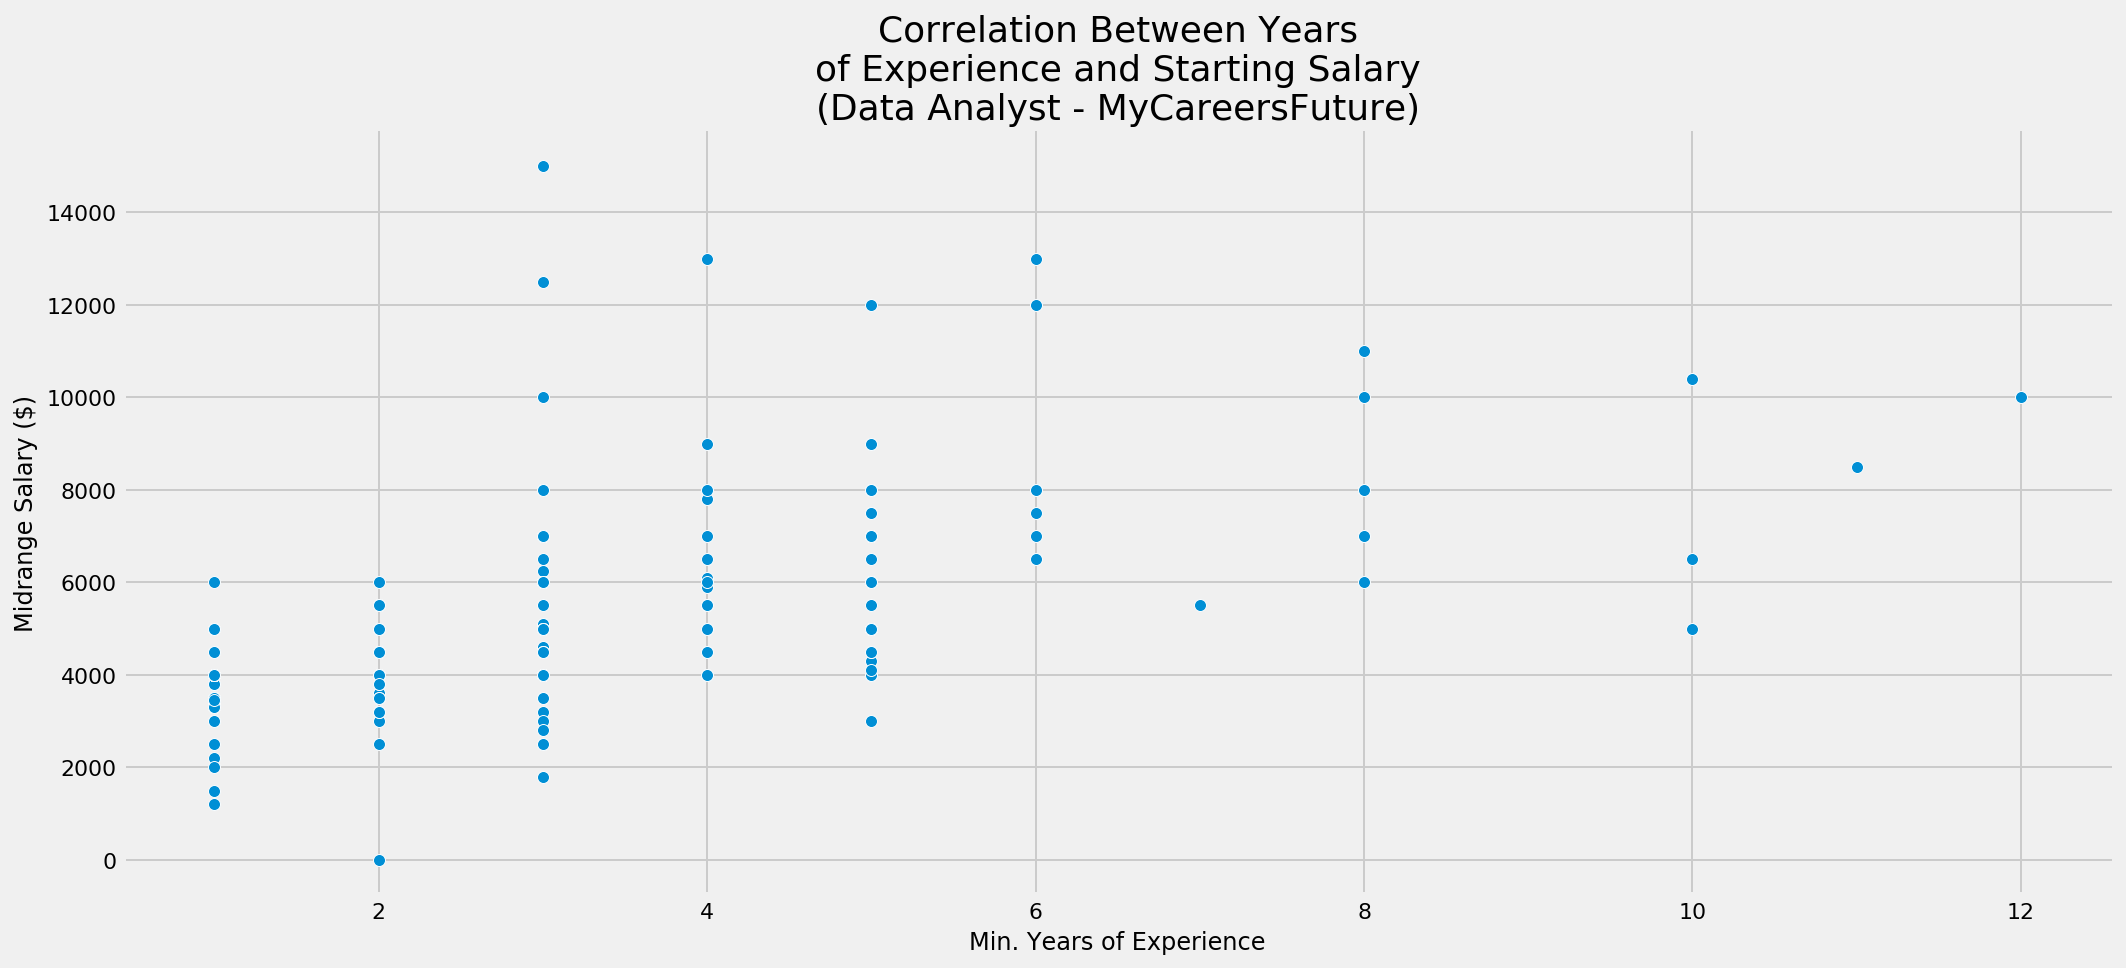

In [100]:
#Plot scatterplot to visualise relationship between years of experience and salary
g_exp_min_sal = sns.scatterplot(x='min_experience',y='min_salary',data=df)
plt.xlabel("Min. Years of Experience", fontsize=12)
plt.ylabel("Midrange Salary ($)", fontsize=12)
plt.title(f"Correlation Between Years\nof Experience and Starting Salary\n({query.title()} - MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

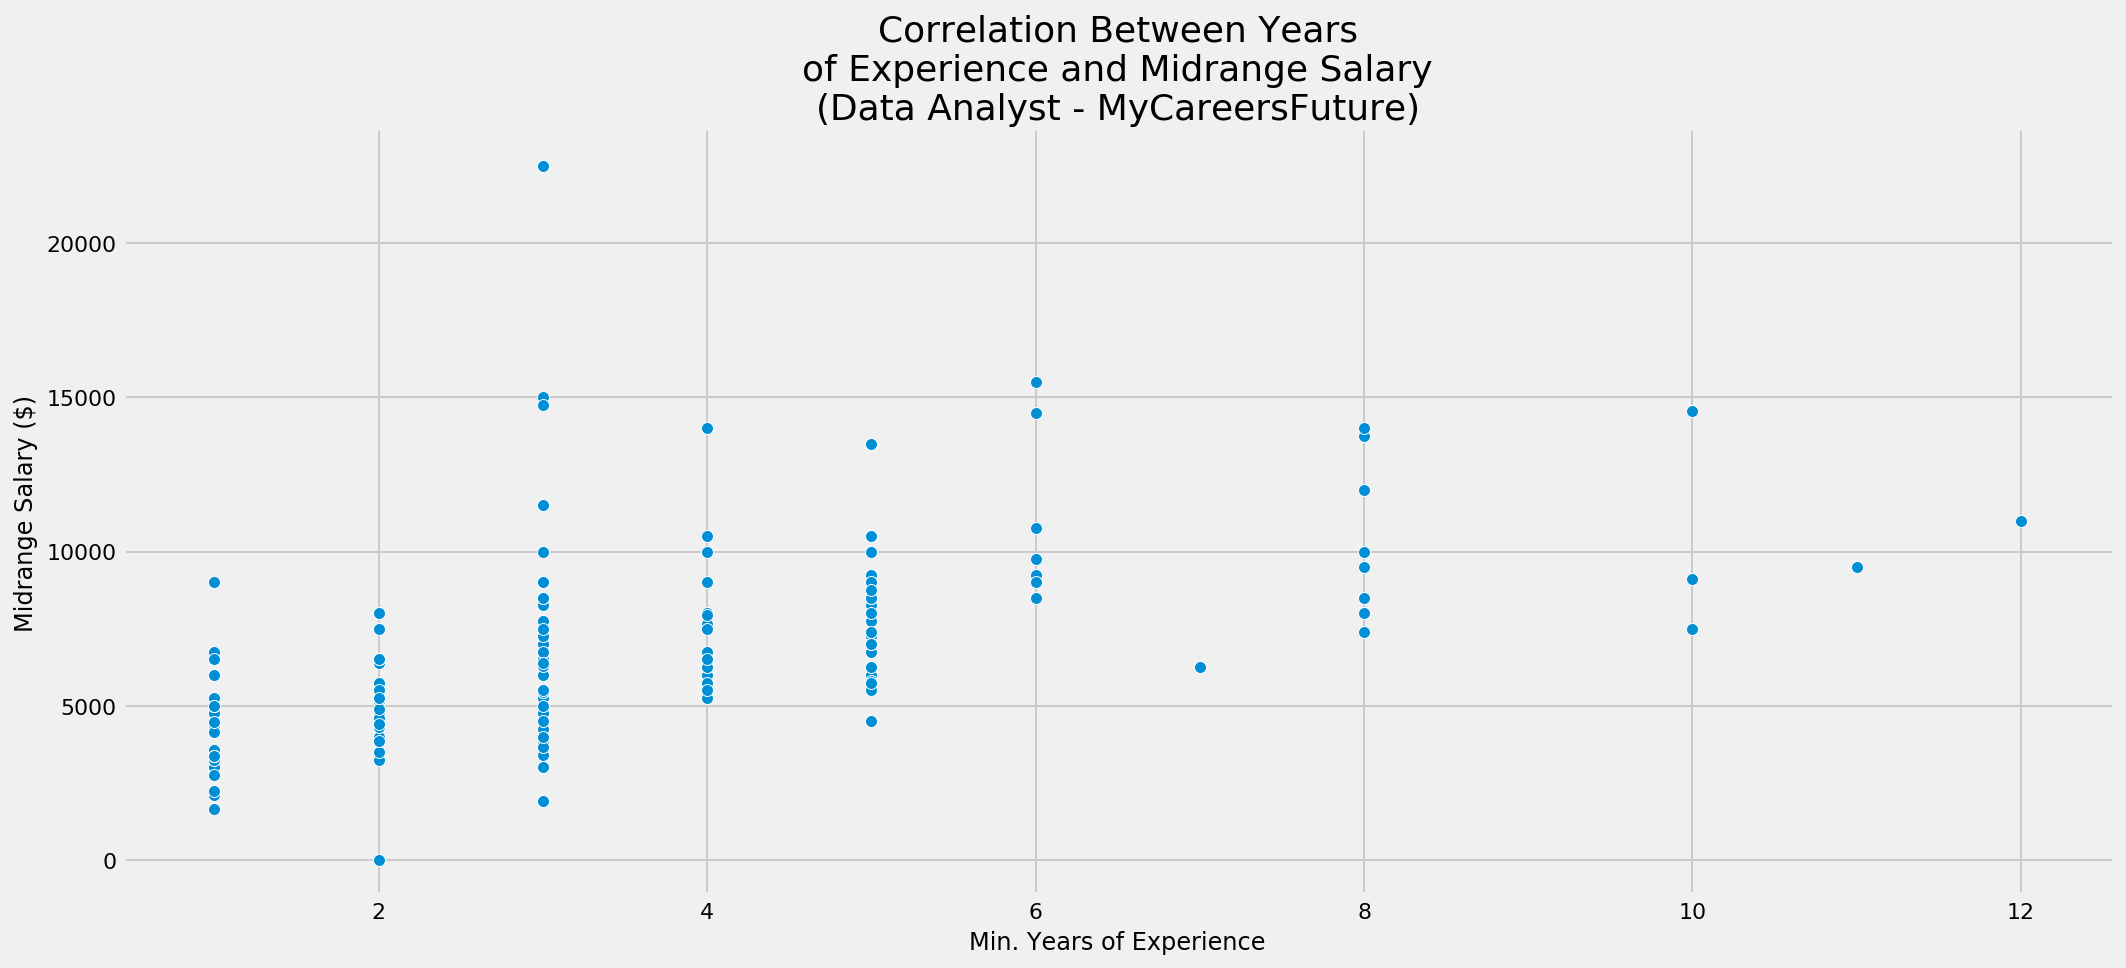

In [101]:
#Plot scatterplot to visualise relationship between years of experience and salary
g_exp_sal = sns.scatterplot(x='min_experience',y='midrange_salary',data=df)
plt.xlabel("Min. Years of Experience", fontsize=12)
plt.ylabel("Midrange Salary ($)", fontsize=12)
plt.title(f"Correlation Between Years\nof Experience and Midrange Salary\n({query.title()} - MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

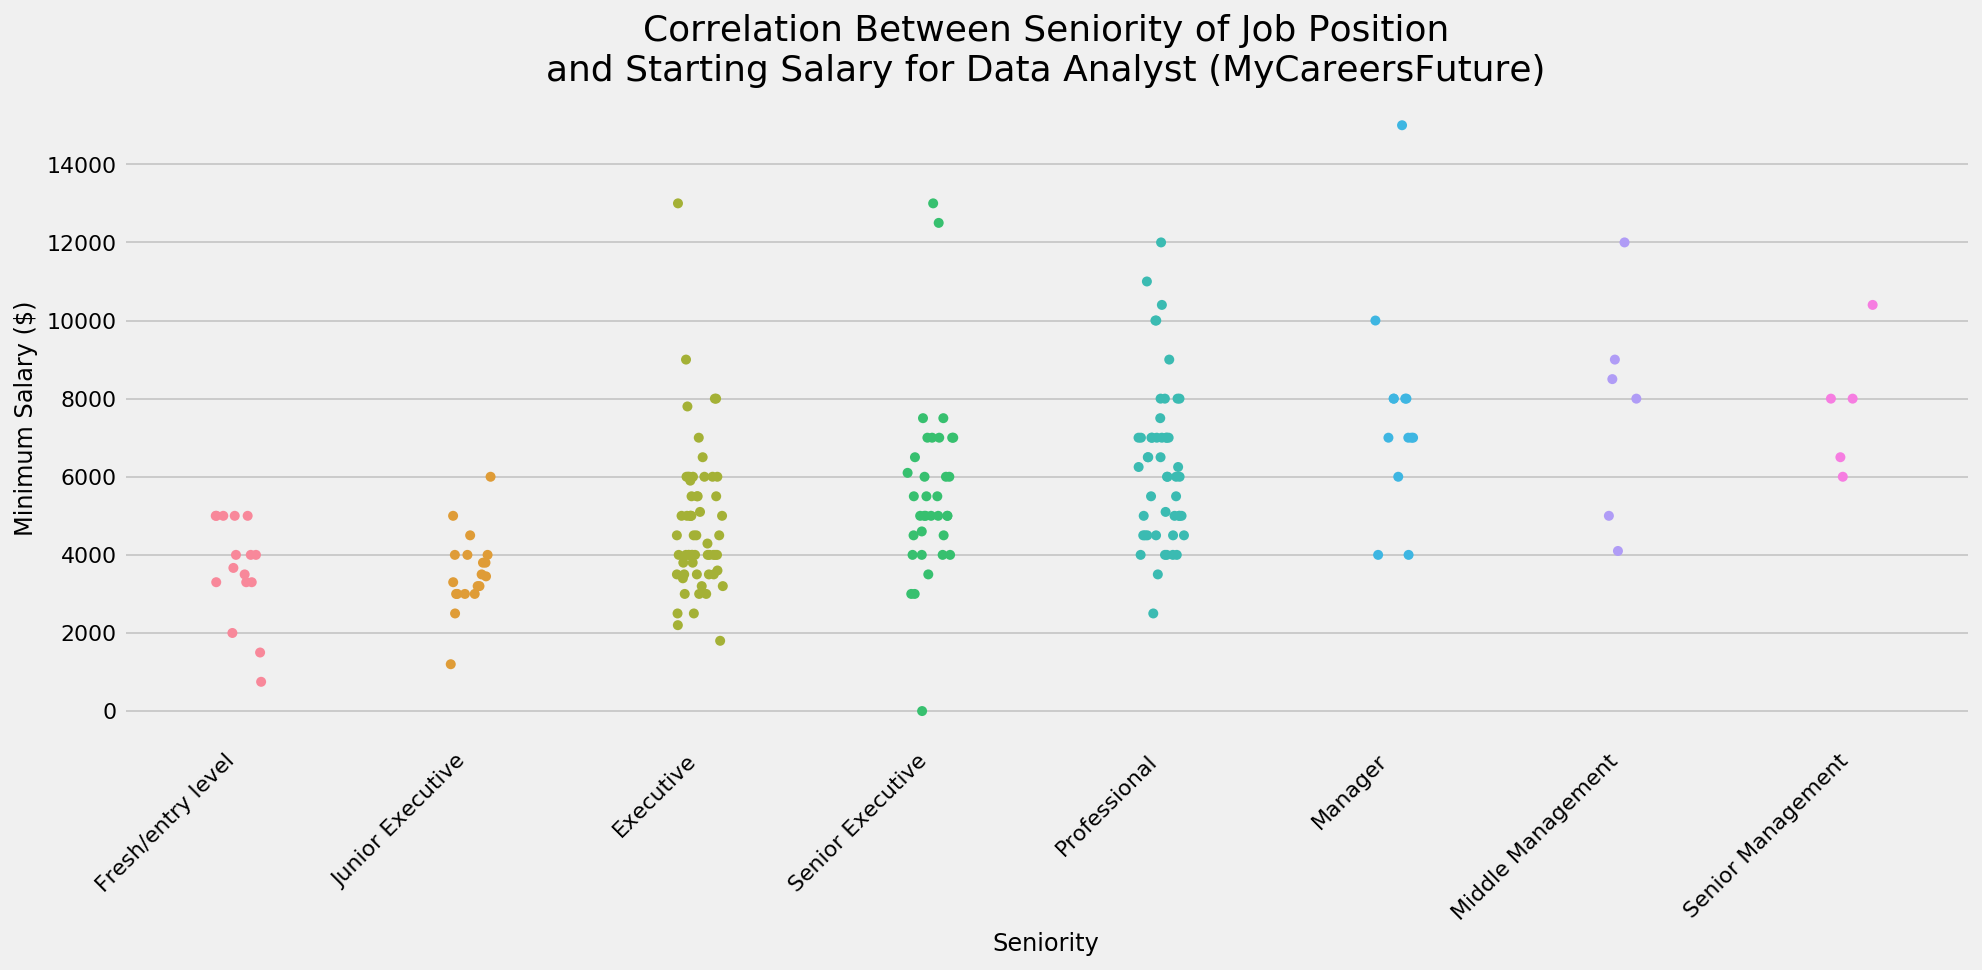

In [102]:
#Plot scatterplot to visualise relationship between minimum salary and seniority of position
order = ['Fresh/entry level','Junior Executive','Executive','Senior Executive','Professional','Manager','Middle Management','Senior Management']
g_sen = sns.catplot(x='seniority',y='min_salary',data=df,height=7,aspect=2, order=order)
plt.xlabel("Seniority", fontsize=12)
plt.xticks(rotation = 45, ha='right')
plt.ylabel("Minimum Salary ($)", fontsize=12)
plt.title(f"Correlation Between Seniority of Job Position\nand Starting Salary for {query.title()} (MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

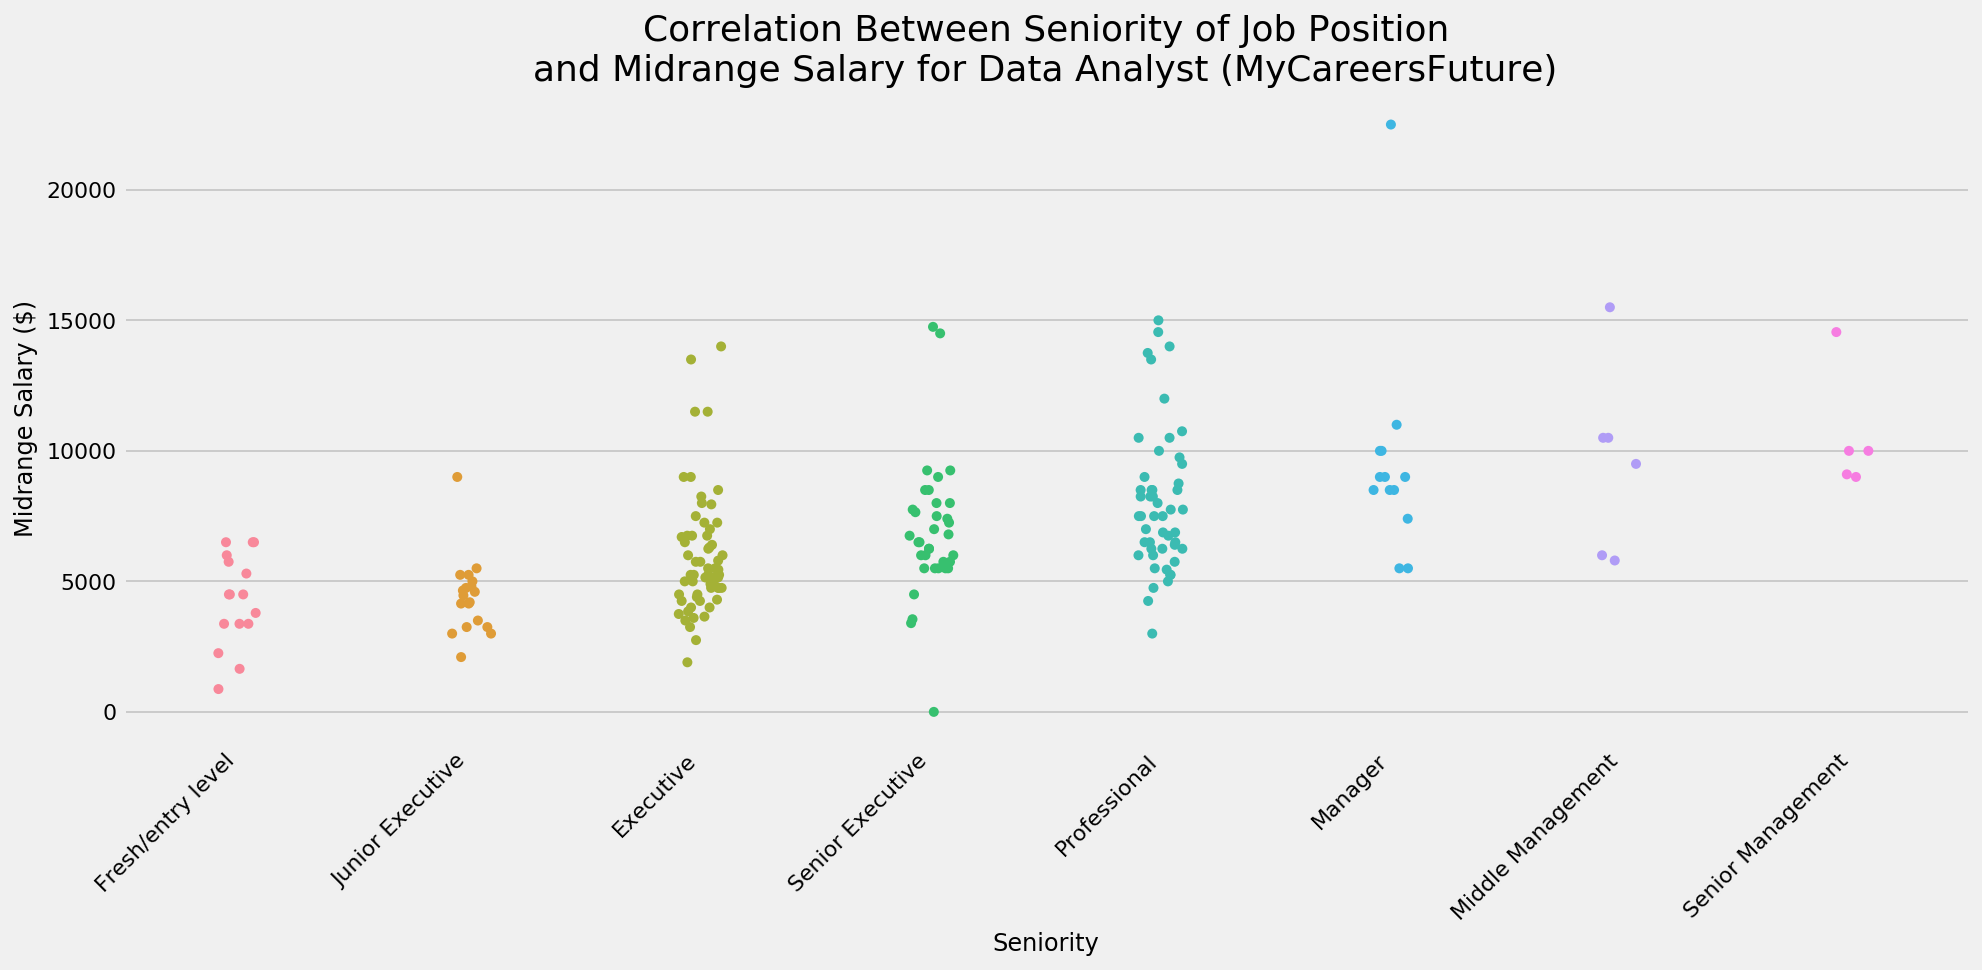

In [103]:
#Plot scatterplot to visualise relationship between midrange salary and seniority of position
order = ['Fresh/entry level','Junior Executive','Executive','Senior Executive','Professional','Manager','Middle Management','Senior Management']
g_sen_midrange = sns.catplot(x='seniority',y='midrange_salary',data=df,height=7,aspect=2, order=order)
plt.xlabel("Seniority", fontsize=12)
plt.xticks(rotation = 45, ha='right')
plt.ylabel("Midrange Salary ($)", fontsize=12)
plt.title(f"Correlation Between Seniority of Job Position\nand Midrange Salary for {query.title()} (MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.show()

In [104]:
#Create new series with each sector from 'sector' column, count the frequency of each sector and sort the results
sorted_sector = df['sector'].str.split(', ').explode('sector').value_counts()

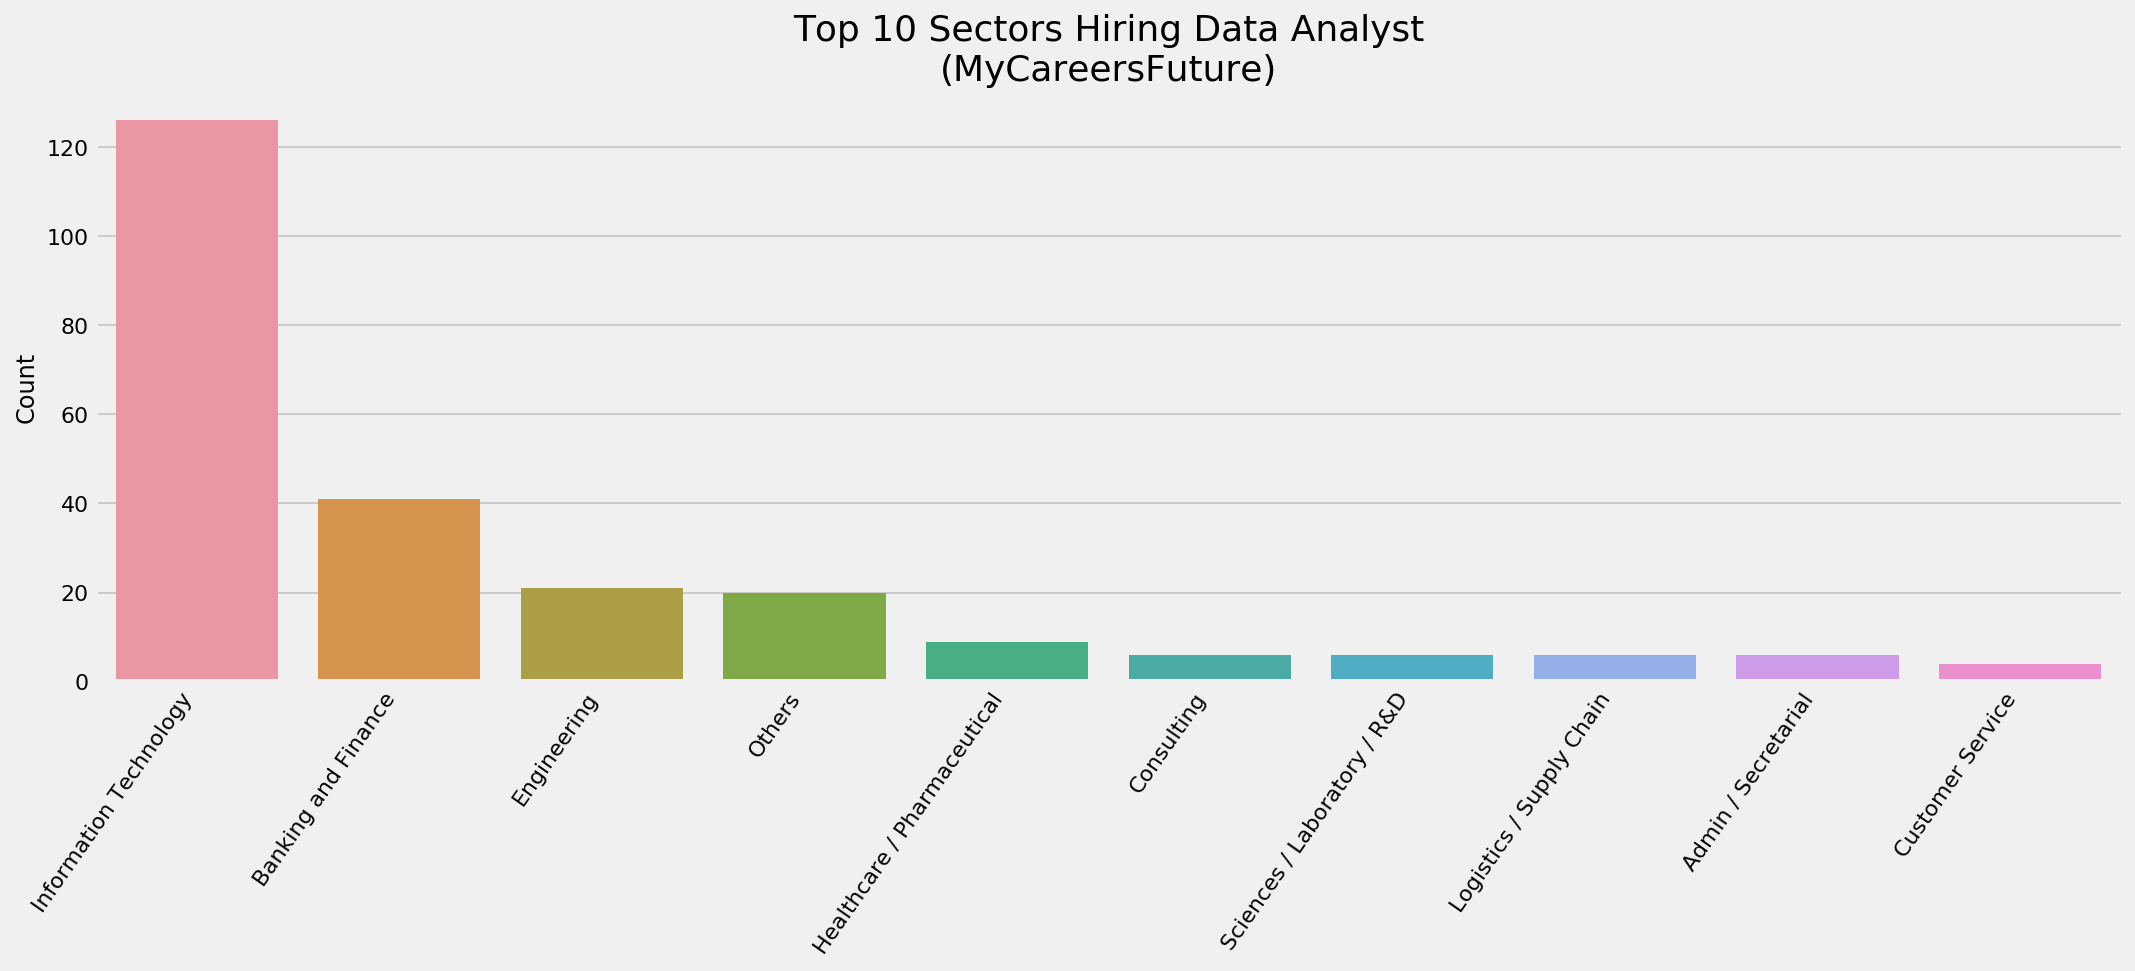

In [105]:
#Create bar plot showing the top 10 sector hiring data analysts in the dataset
g = sns.barplot(x=sorted_sector.head(10).index, y=sorted_sector.head(10).values)
plt.xticks(rotation = 55, ha='right')
plt.title(f"Top 10 Sectors Hiring {query.title()}\n(MyCareersFuture)", fontsize=18)
plt.tight_layout()
plt.ylabel('Count', fontsize=12)
plt.show()